In [1]:
import sys, os

import numpy as np
from umap import UMAP
import time
import torch
import matplotlib.pyplot as plt
import pandas as pd  
import scanpy as sc
import scipy.sparse as sps
import scipy.io as sio
# import scipy.sparse as sp
from os.path import join

import scmomat 

plt.rcParams["font.size"] = 10

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/umap_learn-0.5.3-py3.8.egg/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/umap_learn-0.5.3-py3.8.egg/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/yanx

## Step 1: Load dataset

In [2]:
# Path to the data directory
dat_dir = "/home/yanxh/gitrepo/multi-omics-matching/neurips2021_multimodal_topmethods-main/output/datasets/"
data_dir = os.path.join(dat_dir, "match_modality/openproblems_bmmc_multiome_phase2_rna")
out_dir = '/home/yanxh/gitrepo/multi-omics-matching/neurips2021_multimodal_topmethods-main/output/pretrain/scmomat/bm-cite'

In [3]:
print('Reading `h5ad` files...')
input_train_mod1 = sc.read_h5ad(join(data_dir, 'openproblems_bmmc_multiome_phase2_rna.censor_dataset.output_train_mod1.h5ad'))
input_train_mod2 = sc.read_h5ad(join(data_dir, 'openproblems_bmmc_multiome_phase2_rna.censor_dataset.output_train_mod2.h5ad'))
input_train_sol = sc.read_h5ad(join(data_dir, 'openproblems_bmmc_multiome_phase2_rna.censor_dataset.output_train_sol.h5ad'))
input_test_mod1 = sc.read_h5ad(join(data_dir, 'openproblems_bmmc_multiome_phase2_rna.censor_dataset.output_test_mod1.h5ad'))
input_test_mod2 = sc.read_h5ad(join(data_dir, 'openproblems_bmmc_multiome_phase2_rna.censor_dataset.output_test_mod2.h5ad'))

print("Unscrambling training cells...")
ord = input_train_sol.X.tocsr().indices
train_mod2_ord = ord.copy()
if "pairing_ix" in input_train_sol.uns:
    assert np.all(ord == np.argsort(input_train_sol.uns["pairing_ix"]))
input_train_mod2 = input_train_mod2[ord, :].copy()
input_train_mod2.obs_names = input_train_mod1.obs_names

Reading `h5ad` files...
Unscrambling training cells...


In [4]:
# loading meta data
# rename to be consistent with meta data
def renames(df):
    df['full_names'] = df.index.to_numpy()
    df.index = [_.split('-')[0]+'-'+_.split('-')[1] for _ in df.index]
    return df

root_dir = '/home/yanxh/gitrepo/multi-omics-matching/neurips2021_multimodal_topmethods-main'
df_meta = pd.read_csv(os.path.join(root_dir, 'output/datasets/multiome_meta.csv'), index_col=0)
df_meta = renames(df_meta)
train_idx = ~df_meta.batch.isin(['s4d1', 's4d8', 's4d9'])
test_idx  = df_meta.batch.isin(['s4d1', 's4d8', 's4d9'])

In [6]:
input_train_mod1.obs = renames(input_train_mod1.obs)
input_train_mod2.obs = renames(input_train_mod2.obs)
input_test_mod1.obs = renames(input_test_mod1.obs)

input_train_mod1.obs['batch'] = df_meta.loc[train_idx].loc[input_train_mod1.obs_names, 'batch'].copy()
input_train_mod2.obs['batch'] = df_meta.loc[train_idx].loc[input_train_mod2.obs_names, 'batch'].copy()
input_test_mod1.obs['batch'] = df_meta.loc[test_idx].loc[input_test_mod1.obs_names, 'batch'].copy()

# loading test ord
input_test_sol = sc.read_h5ad(join(data_dir, 'openproblems_bmmc_multiome_phase2_rna.censor_dataset.output_test_sol.h5ad'))
test_ord = input_test_sol.X.tocsr().indices
assert (test_ord == np.argsort(input_test_sol.uns['pairing_ix'])).all()

df_test2 = pd.DataFrame(
    df_meta.loc[test_idx].loc[input_test_mod1.obs_names, ['batch', 'cell_type']].values, 
    index=input_test_mod2.obs_names[test_ord].to_list(),
    columns=['batch', 'cell_type']
)
input_test_mod2.obs['batch'] = df_test2.loc[input_test_mod2.obs_names, 'batch'].copy()

## down scale data

In [7]:
# sc.pp.highly_variable_genes(input_train_mod1, layer='counts', flavor='seurat_v3', n_top_genes=5000)
sc.pp.highly_variable_genes(input_train_mod1, n_top_genes=5000, batch_key='batch')
hvg_names = input_train_mod1.var.query('highly_variable').index.to_numpy()

hvp_idx = np.argsort(input_train_mod2.layers['counts'].sum(axis=0).A1)[-20000:]
hvp_names = input_train_mod2.var_names[hvp_idx].to_numpy()

### format data

In [8]:
genes = hvg_names
peaks = hvp_names
feats_name = {"rna": genes, "atac": peaks}

# split batches
train_batches = input_train_mod1.obs.batch.to_numpy()
test1_batches = input_test_mod1.obs.batch.to_numpy()
test2_batches = input_test_mod2.obs.batch.to_numpy()

train_batches_barcodes, train_batches_list, train_mods = [], [], []
for bi in np.unique(train_batches):
    b_mask = train_batches == bi
    train_batches_barcodes.append(input_train_mod1.obs_names[b_mask].to_numpy())
    train_batches_list.append([bi]*(b_mask.sum()))
    train_mods.append(['multiome']*(b_mask.sum()))
test1_batches_barcodes, test1_batches_list, test1_mods = [], [], []
for bi in np.unique(test1_batches):
    b_mask = test1_batches == bi
    test1_batches_barcodes.append(input_test_mod1.obs_names[b_mask].to_numpy())
    test1_batches_list.append([bi]*b_mask.sum())
    test1_mods.append(['rna']*(b_mask.sum()))
test2_batches_barcodes, test2_batches_list, test2_mods = [], [], []
for bi in np.unique(test2_batches):
    b_mask = test2_batches == bi
    test2_batches_barcodes.append(input_test_mod2.obs_names[b_mask].to_numpy())
    test2_batches_list.append([bi]*b_mask.sum())
    test2_mods.append(['atac']*(b_mask.sum()))
    
barcodes = [*train_batches_barcodes, *test1_batches_barcodes, *test2_batches_barcodes]
batches = [*train_batches_list, *test1_batches_list, *test2_batches_list]
mods = [*train_mods, *test1_mods, *test2_mods]

n_batches = len(barcodes)

In [9]:
# READ IN THE COUNT MATRICES
# scRNA-seq of batch
counts_rnas = []
for bc in train_batches_barcodes:
    count = scmomat.preprocess(input_train_mod1[bc, hvg_names].layers['counts'].A, modality = "RNA", log = False)
    counts_rnas.append(count)
for bc in test1_batches_barcodes:
    count = scmomat.preprocess(input_test_mod1[bc, hvg_names].layers['counts'].A, modality = "RNA", log = False)
    counts_rnas.append(count)
for bc in test2_batches_barcodes:
    counts_rnas.append(None)

counts_atacs = []
for bc in train_batches_barcodes:
    count = scmomat.preprocess(input_train_mod2[bc, hvp_names].layers['counts'].A, modality = "ATAC", log = False)
    counts_atacs.append(count)
for bc in test1_batches_barcodes:
    counts_atacs.append(None)
for bc in test2_batches_barcodes:
    count = scmomat.preprocess(input_test_mod2[bc, hvp_names].layers['counts'].A, modality = "ATAC", log = False)
    counts_atacs.append(count)

In [10]:
# CREATE THE COUNTS OBJECT
counts = {"feats_name": feats_name, "nbatches": n_batches, "rna":counts_rnas, "atac": counts_atacs}

## Step 2: training scMoMaT
The hyper-parameter includes `lamb` for weight lambda in the objective function, `K` for the number of latent dimensions. The default parameter (`lamb = 0.001`, `K = 30`) works for most of the real datasets.

Input sanity check...
Finished.
Epoch 1, Validating Loss: 1350.2523
	 loss reconstruction: 1.34791
	 loss regularization: 2.34000
Epoch 1000, Validating Loss: 1190.9897
	 loss reconstruction: 1.19097
	 loss regularization: 0.02443
Epoch 2000, Validating Loss: 1188.0363
	 loss reconstruction: 1.18800
	 loss regularization: 0.03708
Epoch 3000, Validating Loss: 1186.7516
	 loss reconstruction: 1.18672
	 loss regularization: 0.02951
Epoch 4000, Validating Loss: 1185.9994
	 loss reconstruction: 1.18598
	 loss regularization: 0.01869
running time: 575.3490951061249


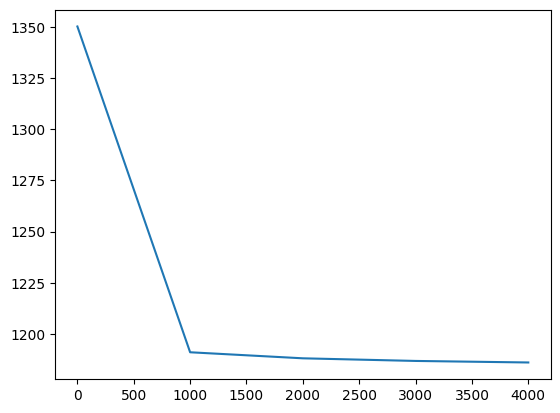

In [11]:
#------------------------------------------------------------------------------------------------------------------------------------
# NOTE: Number of latent dimensions, key hyper-parameter, 20~30 works for most of the cases.
K = 30
lamb = 0.001 
T = 4000     
interval = 1000
batch_size = 0.1
lr = 1e-2
seed = 0
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

#------------------------------------------------------------------------------------------------------------------------------------

start_time = time.time()
model = scmomat.scmomat_model(counts = counts, K = K, batch_size = batch_size, interval = interval, lr = lr, lamb = lamb, seed = seed, device = device)
losses = model.train_func(T = T)
end_time = time.time()
print("running time: " + str(end_time - start_time))

x = np.linspace(0, T, int(T/interval)+1)
plt.plot(x, losses)

# inference

In [12]:
umap_op = UMAP(n_components = 2, n_neighbors = 30, min_dist = 0.2, random_state = 0) 
zs = model.extract_cell_factors()
x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))

In [13]:
# read in the ground truth labels
# NOTE: Plot the result before post-processing
labels = []
for bc in train_batches_barcodes:
    labels.append(df_meta.loc[train_idx].loc[bc, 'cell_type'].to_numpy())
for bc in test1_batches_barcodes:
    labels.append(df_meta.loc[test_idx].loc[bc, 'cell_type'].to_numpy())
    
for bc in test2_batches_barcodes:
    labels.append(df_test2.loc[bc, 'cell_type'].to_numpy())

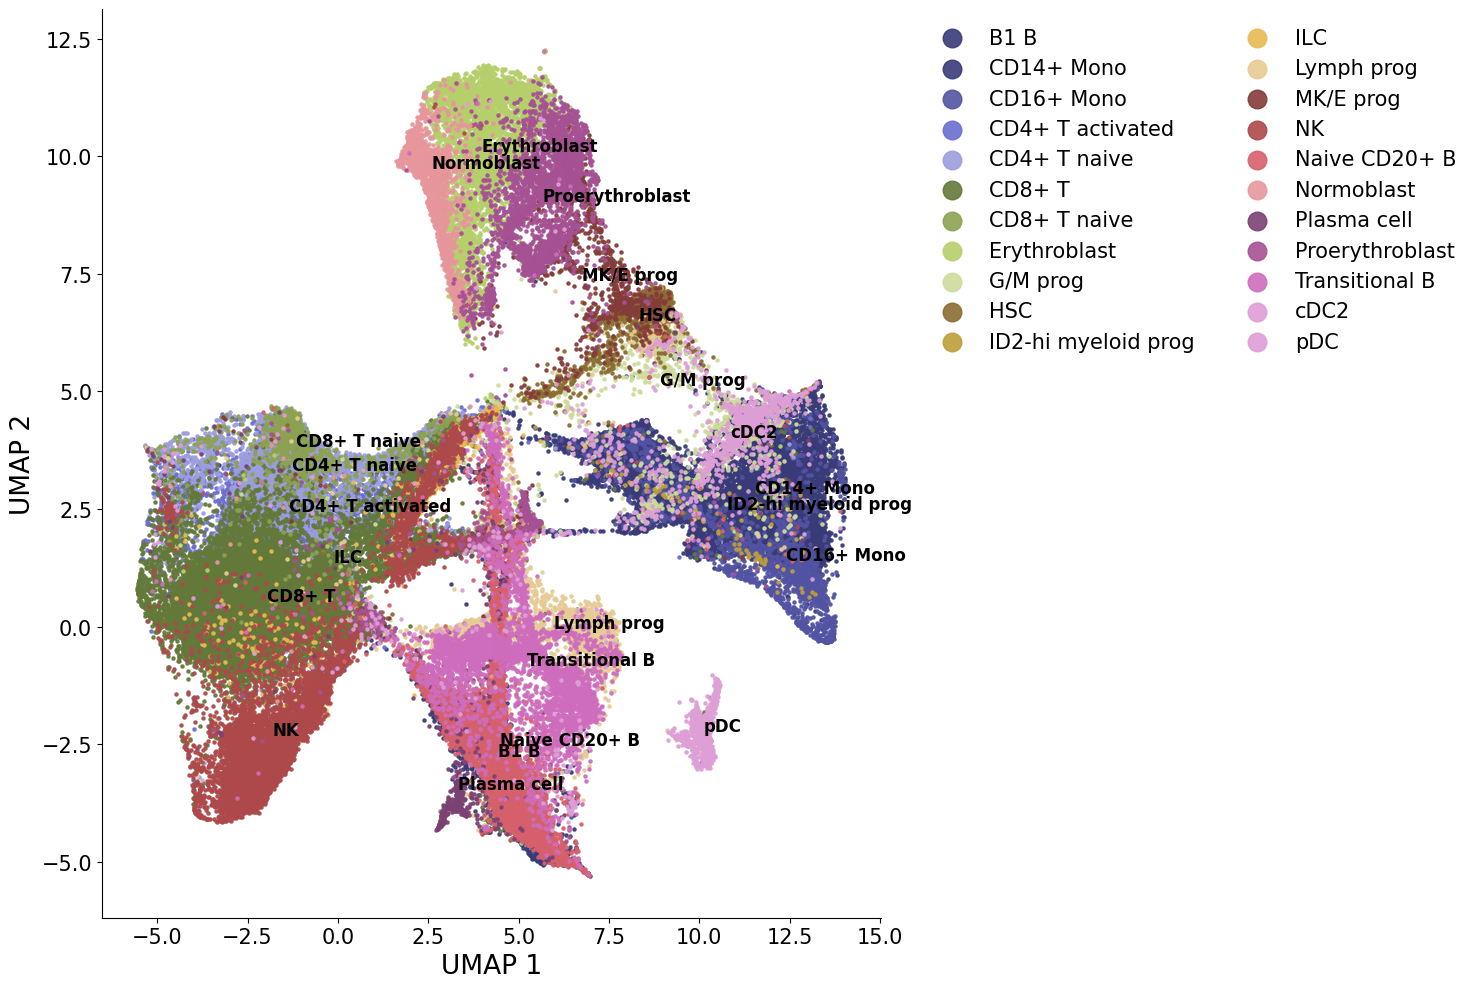

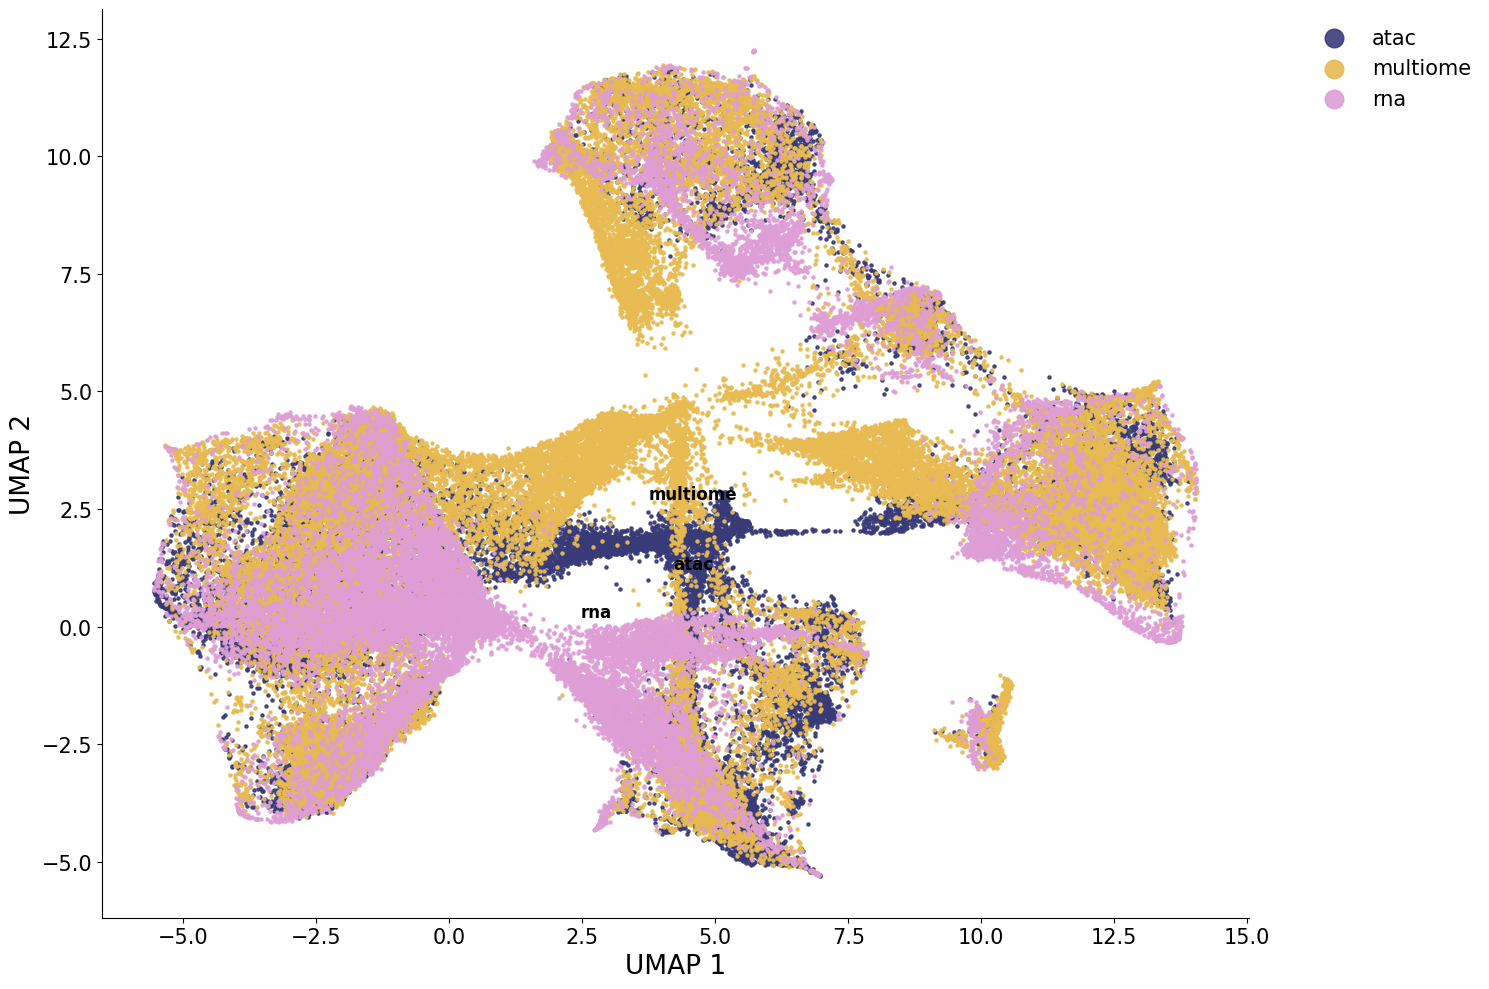

In [14]:
scmomat.plot_latent(x_umap, annos = np.concatenate(labels), 
                    mode = "joint", save = None, 
                    figsize = (15,10), axis_label = "UMAP", markerscale = 6, s = 5, label_inplace = True)
scmomat.plot_latent(x_umap, annos = np.concatenate(mods), 
                    mode = "joint", save = None, 
                    figsize = (15,10), axis_label = "UMAP", markerscale = 6, s = 5, label_inplace = True)

## Step 3: Post-processing
The hyper-parameter includes `n_neighbors` and `r`. Use `r = None` unless the cell type composition is highly unmatched. In the unmatched case, `r` can be set between `0.5` and `1`, where a smaller values means lower batch correction. `n_neighbors` should be adjusted according to the total number of batches, usually `5-15` for each batch would be enough.

calculating pairwise distance, time used 54.7665s
knn separate, time used 35.5583s
modify distance, time used 0.1339s
not unique
using precompute
Provided KNN...
random intialization...


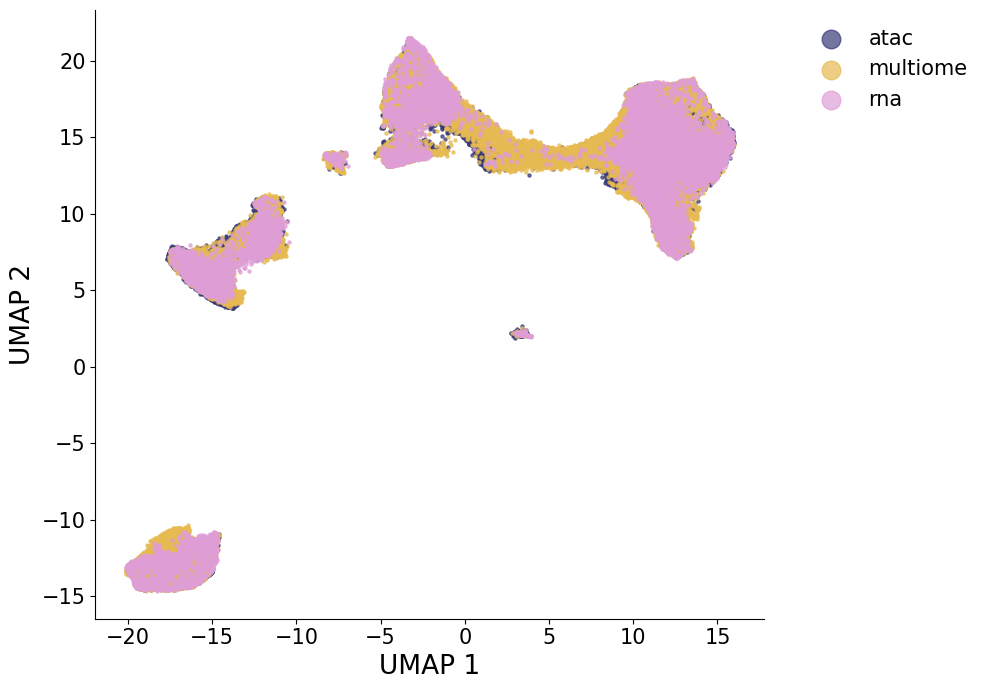

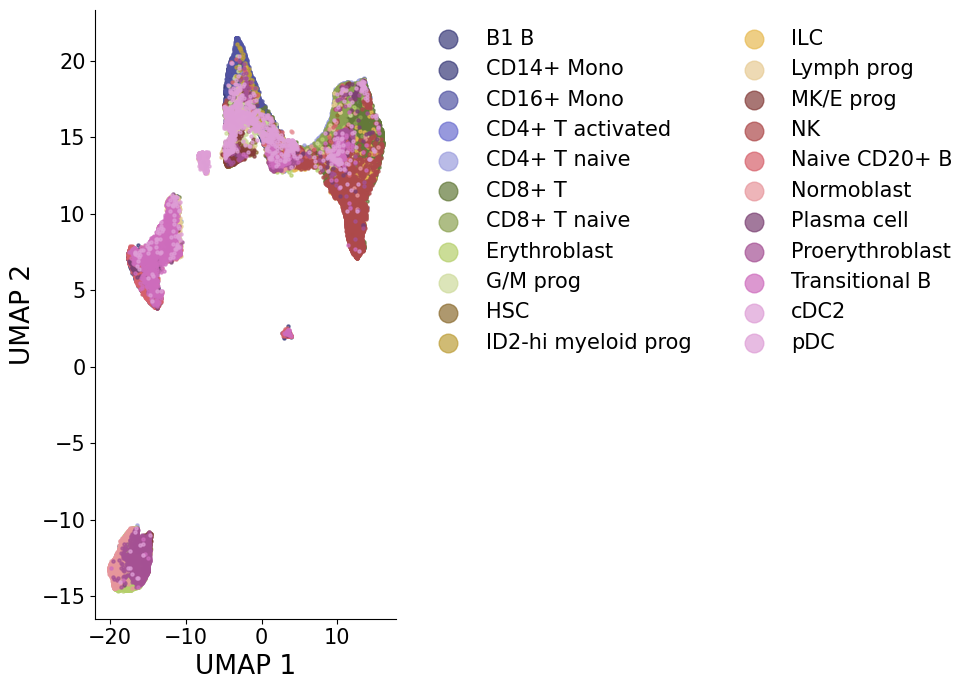

In [15]:
zs = model.extract_cell_factors()

n_neighbors = 100
r = None
resolution = 0.9
knn_indices, knn_dists = scmomat.calc_post_graph(zs, n_neighbors, njobs = 8, r = r)
# labels_leiden = scmomat.leiden_cluster(X = None, knn_indices = knn_indices, knn_dists = knn_dists, resolution = resolution)
x_umap = scmomat.calc_umap_embedding(
    knn_indices = knn_indices, knn_dists = knn_dists, 
    n_components = 2, n_neighbors = n_neighbors, min_dist = 0.20, random_state = 0)

scmomat.plot_latent(x_umap, 
                    annos=np.concatenate(mods),
                    mode = "joint", save = None,\
                      figsize = (10,7), axis_label = "UMAP", 
                    markerscale = 6, s = 5, label_inplace = False, alpha = 0.7)

scmomat.plot_latent(x_umap, 
                    annos=np.concatenate(labels),
                    mode = "joint", save = None,\
                      figsize = (10,7), axis_label = "UMAP", 
                    markerscale = 6, s = 5, label_inplace = False, alpha = 0.7)

# Eval results

In [16]:
ad_mosaic = sc.AnnData(np.vstack(zs), obsm={"X_emb":np.vstack(zs)})
ad_mosaic.obs['batch'] = np.hstack(batches)
ad_mosaic.obs['mod']   = np.hstack(mods)
ad_mosaic.obs['cell_type'] = np.hstack(labels)
ad_mosaic.obs['mod-batch'] = (ad_mosaic.obs['mod'] + '-' + ad_mosaic.obs.batch).to_numpy()

ad_mosaic.obsm['X_umap'] = x_umap
ad_mosaic.obsp['connectivities'] = scmomat.utils._compute_connectivities_umap(
    knn_indices = knn_indices, knn_dists = knn_dists, 
    n_neighbors = 15, set_op_mix_ratio=1.0, local_connectivity=1.0
)
ad_mosaic.uns['neighbors'] = {'connectivities_key':'connectivities'}

In [17]:
import sys
sys.path.insert(0, '/home/yanxh/gitrepo/multi-omics-matching/ACE/reproduce/evaluation')

from evaluation import eval_mosaic, eval_bridge, print_results, eval_lisi, eval_clustering

def get_umap(adata, use_rep='X_emb_shr'):
    sc.pp.neighbors(adata, n_neighbors=15, use_rep=use_rep)
    sc.tl.umap(adata)
    return adata

In [18]:
# mosaic eval
r = eval_mosaic(ad_mosaic, label_key='cell_type', batch_keys=['mod-batch', 'mod'], 
                use_lisi=True, use_gc=False, use_rep='X_emb', use_nmi=False, use_neighbors=True)

cell_type_LISI=0.93391
mod-batch_LISI=0.63646
mod_LISI=0.77599


In [19]:
# nmi, ari using nmi search
nmi, ari = eval_clustering(
    ad_mosaic, label_key='cell_type', cluster_key='cluster', resolutions=None, use_rep='X_emb', use_neighbors=True,
    use='nmi', nmi_method='arithmetic')
nmi, ari

(0.5367933924396472, 0.40199549628469516)

In [20]:
ad_gex_test = sc.AnnData(np.vstack(zs[-6:-3]), obsm={"X_emb":np.vstack(zs[-6:-3])})
ad_atac_test = sc.AnnData(np.vstack(zs[-3:]), obsm={"X_emb":np.vstack(zs[-3:])})
ad_gex_test.obs_names = np.hstack(barcodes[-6:-3])
ad_atac_test.obs_names = np.hstack(barcodes[-3:])
ad_gex_test.obs['batch'] = np.hstack(batches[-6:-3])
ad_atac_test.obs['batch'] = np.hstack(batches[-3:])
ad_gex_test.obs['cell_type'] = np.hstack(labels[-6:-3])
ad_atac_test.obs['cell_type'] = np.hstack(labels[-3:])

ad_gex_test = ad_gex_test[input_test_mod1.obs_names.to_numpy()].copy()
ad_atac_test = ad_atac_test[input_test_mod2.obs_names.to_numpy()][test_ord, :].copy()  # reorder
assert (ad_gex_test.obs.batch.to_numpy()==ad_atac_test.obs.batch.to_numpy()).all()

r = eval_bridge(
    ad_gex_test, ad_atac_test,
    label_key='cell_type',
    batch_key='batch',
    use_rep='X_emb',
    use_acc=False
)

FOSCTTM=0.14063
Match_score=0.00478


# save plots

In [18]:
umap_save_dir = '/home/sda1/yanxh/outputs/umap_plots'

In [19]:
def get_umap(adata, use_rep='X_emb_shr', add_key=None):
    sc.pp.neighbors(adata, n_neighbors=15, use_rep=use_rep)
    sc.tl.umap(adata)
    
    add_key = 'X_umap' if add_key is None else add_key
    adata.obsm[add_key] = adata.obsm['X_umap']
    return adata

def save_umap(adata, use_rep, colors, is_title='', legend_loc=None, save_dir=None, prefix_name=None):
    for c in colors:
        sc.pl.embedding(adata, basis=use_rep, color=[c], legend_fontsize=4, legend_loc=legend_loc,
              frameon=False, legend_fontoutline=2, show=False, title=is_title) # cmap=reds, vmin=0.00001, 
        plt.savefig(f"{save_dir}/{prefix_name}_{c}_legend={legend_loc}.jpg", bbox_inches="tight", dpi=300)

In [21]:
ad_mosaic.obs['mod'].unique()

['multiome', 'rna', 'atac']
Categories (3, object): ['atac', 'multiome', 'rna']

In [22]:
modD = {'atac':'other', 'multiome':'multiome', 'rna':'gex'}
ad_mosaic.obs['mod2'] = [modD[_] for _ in ad_mosaic.obs['mod']]
ad_mosaic.obs['mod-batch2'] = ad_mosaic.obs['mod2'].astype('str') + '-' + ad_mosaic.obs.batch.astype('str')

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax

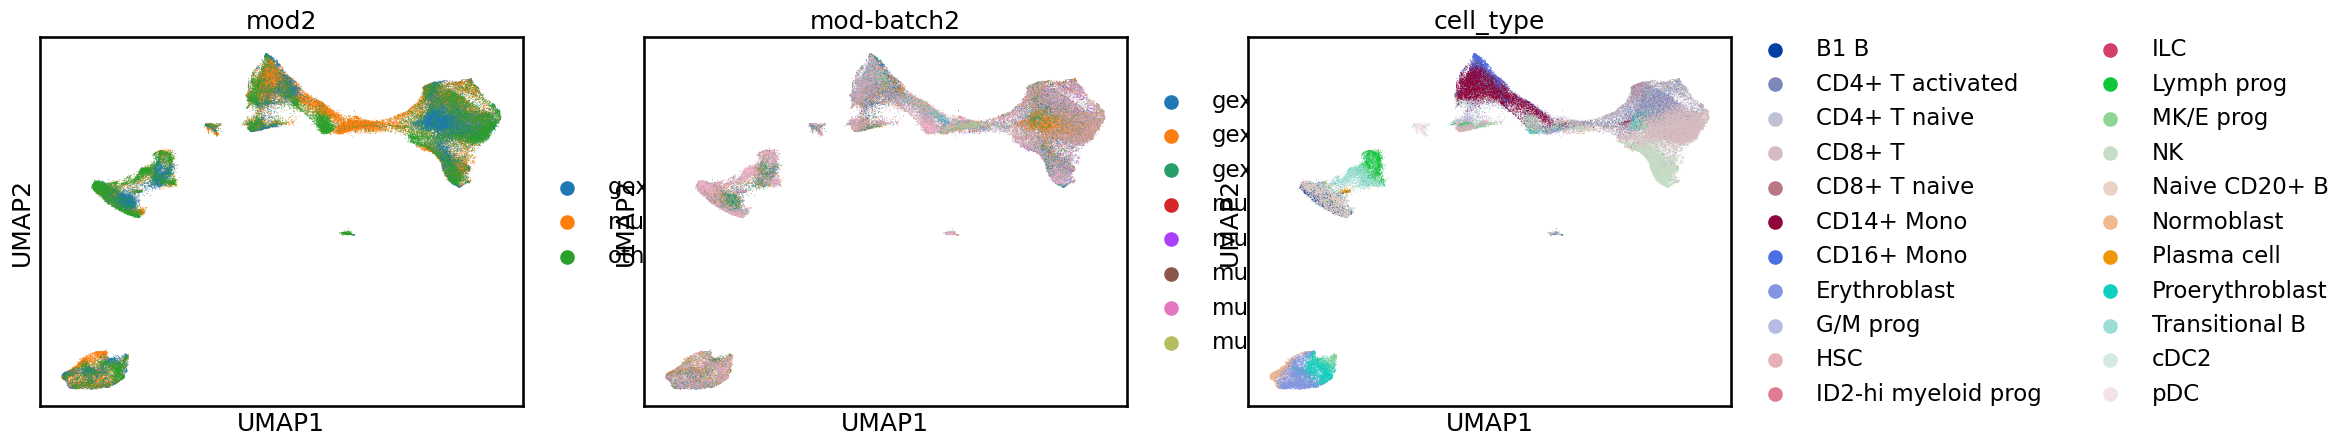

In [23]:
sc.pl.umap(ad_mosaic, color=['mod2', 'mod-batch2', 'cell_type'])

/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/multi-omics/lib/python3.8/site-packages

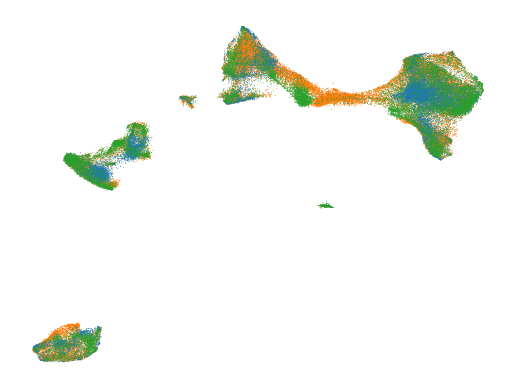

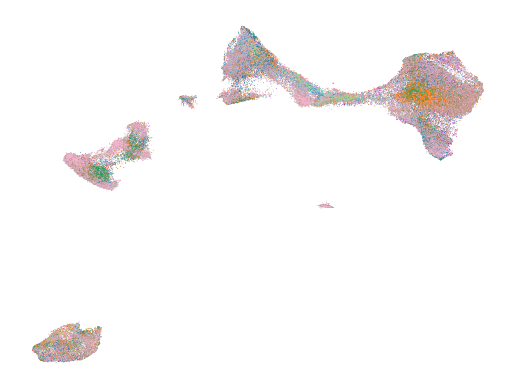

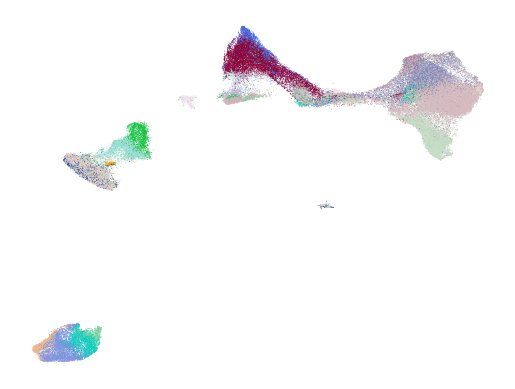

In [24]:
save_umap(ad_mosaic, 'X_umap', ['mod2', 'mod-batch2', 'cell_type'], is_title='', legend_loc=None, 
          save_dir='/home/yanxh/gitrepo/multi-omics-matching/Visualization/Figures/sec1/umap', 
          prefix_name='scMoMaT_case2_multiome')

In [25]:
np.save(join(umap_save_dir, 'scMoMaT_case2_multiome_umap.npy'), ad_mosaic.obsm['X_umap'])